In [1]:
import glob
import json
import pandas as pd

results = []
paths = glob.glob('../output/GoEmotions/transfer-vent/*.json', recursive=True)
paths += glob.glob('../output/GoEmotions/replica/*.json', recursive=True)
for path in paths:
    with open(path) as fp:
        result_dict = json.load(fp)
        result_tuple = (path, result_dict)
        results.append(result_tuple)

results_df = pd.DataFrame(results, columns=['Path', 'Dict'])

In [2]:
EXPERIMENT_METRICS = ['macro_f1', 'micro_f1']
EXPERIMENT_COLUMNS = ['Dataset', 'ModelType', 'Experiment']
INTERNAL_METRICS = ['precision', 'recall']
WEIGHT_FIELD = 'support'


def parse_path(path):
    dataset, model_type, experiment = path.split('/')[-3:]
    experiment = experiment.split('.')[0]
    return dataset, model_type, experiment


def build_experiment_columns(dataframe):
    path_parts = [parse_path(path) for path in dataframe.Path]
    for i, col in enumerate(EXPERIMENT_COLUMNS):
        dataframe[col] = [parts[i] for parts in path_parts]
    return dataframe


def extract_macro_stats(dataframe, metrics=EXPERIMENT_METRICS):
    try:
        split_names = dataframe['Dict'][0]['config']['data_config']['split_names']
    except IndexError:
        split_names = ['train', 'valid', 'test']
    for split in split_names:
        for metric in metrics:
            new_col_name = '{}_{}'.format(split, metric)
            dataframe[new_col_name] = [exp_dict['results'][split][metric] for exp_dict in dataframe['Dict']]
    return dataframe


def extract_category_stats(dataframe, metrics=INTERNAL_METRICS, weight_field=WEIGHT_FIELD):
    try:
        split_names = dataframe['Dict'][0]['config']['data_config']['split_names']
    except IndexError:
        split_names = ['train', 'valid', 'test']
    for split in split_names:
        for metric in metrics:
            new_col_name = '{}_{}'.format(split, metric)
            metric_dict = []
            for exp_dict in dataframe['Dict']:
                label_values = list(exp_dict['results'][split]['labels'].values())
                global_weight = sum(label_results[weight_field] for label_results in label_values)
                metric_score = sum(label_results[weight_field] * label_results[metric] / global_weight
                                   for label_results in label_values)
                metric_dict.append(metric_score)
            dataframe[new_col_name] = metric_dict
    return dataframe


def extract_model_details(dataframe):
    dataframe['Extractor'] = [exp_dict['config']['extractor_config']['ex_type'] for exp_dict in dataframe['Dict']]
    dataframe['Model'] = [exp_dict['config']['model_config']['model_name'] for exp_dict in dataframe['Dict']]
    return dataframe


def parse_df(dataframe):
    dataframe = build_experiment_columns(dataframe)
    dataframe = extract_model_details(dataframe)
    dataframe = extract_macro_stats(dataframe)
    dataframe = extract_category_stats(dataframe)
    return dataframe


In [3]:
parsed_df = parse_df(results_df)
parsed_df['Dataset'] = [row.Dataset if row.Dataset != 'large-grid' else row.Path.split('/')[2]
                        for i, row in parsed_df[['Dataset', 'Path']].iterrows()]
parsed_df['SplitType'] = [d['config']['data_config']['split_mode'] for d in parsed_df.Dict]
parsed_df = parsed_df[parsed_df.Extractor == 'bert']
parsed_df['PretrainedModel'] = [cfg['config'].get('pretrained_model_path', '') for cfg in parsed_df.Dict]

parsed_df.sort_values('valid_macro_f1')

<ipython-input-3-e7f5d7a4b24d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parsed_df['PretrainedModel'] = [cfg['config'].get('pretrained_model_path', '') for cfg in parsed_df.Dict]


,Path,Dict,Dataset,ModelType,Experiment,Extractor,Model,train_macro_f1,train_micro_f1,valid_macro_f1,...,test_macro_f1,test_micro_f1,train_precision,train_recall,valid_precision,valid_recall,test_precision,test_recall,SplitType,PretrainedModel
41,../output/GoEmotions/transfer-vent/a18469f90a0...,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,a18469f90a04478177375ee63e70d05e,bert,lstm,0.523377,0.597671,0.464783,...,0.476945,0.564820,0.558795,0.655911,0.526405,0.616458,0.536778,0.623321,column,models/Vent/fractions-with-test/1447b8ae0ef291...
126,../output/GoEmotions/transfer-vent/3102c3fa5e6...,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,3102c3fa5e6d34ccdd4ee17569c707cb,bert,lstm,0.523377,0.597671,0.464783,...,0.476945,0.564820,0.558795,0.655911,0.526405,0.616458,0.536778,0.623321,column,models/Vent/fractions-with-test/0b80ea9a02d87c...
94,../output/GoEmotions/transfer-vent/df6ebcc2728...,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,df6ebcc27284717c91ccf9903632a562,bert,lstm,0.523377,0.597671,0.464783,...,0.476945,0.564820,0.558795,0.655911,0.526405,0.616458,0.536778,0.623321,column,models/Vent/fractions-with-test/8ba324ac67ab81...
73,../output/GoEmotions/transfer-vent/929d6096de9...,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,929d6096de9165e6b6a0e32d1d34d864,bert,lstm,0.528984,0.602383,0.464824,...,0.470643,0.565236,0.575599,0.643074,0.546465,0.601254,0.535570,0.626481,column,models/Vent/fractions-with-test/54f70325d9a3af...
136,../output/GoEmotions/transfer-vent/7b54897fbbf...,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,7b54897fbbfec6883cf73560a44332a6,bert,lstm,0.528984,0.602383,0.464824,...,0.470643,0.565236,0.575599,0.643074,0.546465,0.601254,0.535570,0.626481,column,models/Vent/fractions-with-test/a8c98925ac93a3...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,../output/GoEmotions/transfer-vent/8b820642185...,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,8b8206421855c40ba882db6ad73c9e33,bert,dnnpool,0.567621,0.613692,0.509986,...,0.490169,0.554900,0.578733,0.666399,0.526118,0.634796,0.505349,0.639438,column,models/Vent/fractions-with-test/790b902ed8baf1...
39,../output/GoEmotions/transfer-vent/fc3808c69ab...,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,fc3808c69ab4f577d58654059fc1dfa9,bert,dnnpool,0.567621,0.613692,0.509986,...,0.490169,0.554900,0.578733,0.666399,0.526118,0.634796,0.505349,0.639438,column,models/Vent/fractions-with-test/0b80ea9a02d87c...
101,../output/GoEmotions/transfer-vent/2a28b6118b0...,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,2a28b6118b034e2792da1d3387fba6a0,bert,dnnpool,0.567621,0.613692,0.509986,...,0.490169,0.554900,0.578733,0.666399,0.526118,0.634796,0.505349,0.639438,column,models/Vent/fractions-with-test/1447b8ae0ef291...
2,../output/GoEmotions/transfer-vent/508af09dd5d...,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,508af09dd5d579c62c291546c3fb78d5,bert,dnnpool,0.567621,0.613692,0.509986,...,0.490169,0.554900,0.578733,0.666399,0.526118,0.634796,0.505349,0.639438,column,models/Vent/fractions-with-test/3f6874d7253a1d...


In [4]:
df_column_experiments = parsed_df[parsed_df.SplitType == 'column']
keyed_groups = df_column_experiments.groupby(['Dataset', 'ModelType', 'Extractor', 'Model', 'PretrainedModel'])
best_valid_df = keyed_groups.valid_macro_f1.max().to_frame().reset_index()

results_df = parsed_df.merge(best_valid_df, on=['Dataset', 'ModelType', 'Extractor', 'Model', 'PretrainedModel', 'valid_macro_f1'], how='inner')

final_df = results_df[['Dict', 'Dataset', 'ModelType', 'Extractor', 'Model', 'PretrainedModel', 'test_macro_f1', 'test_micro_f1', 'test_precision', 'test_recall']]
final_df = final_df.drop_duplicates(['Dataset', 'ModelType', 'Extractor', 'Model', 'PretrainedModel']).sort_values(['Dataset', 'Extractor', 'Model'])
final_df = final_df[final_df.Extractor == 'bert']
final_df

,Dict,Dataset,ModelType,Extractor,Model,PretrainedModel,test_macro_f1,test_micro_f1,test_precision,test_recall
0,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/19e7a6295ccc3e...,0.490169,0.554900,0.505349,0.639438
1,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/3f6874d7253a1d...,0.490169,0.554900,0.505349,0.639438
7,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/0585fa2c337506...,0.491188,0.555580,0.517800,0.621741
8,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/0b80ea9a02d87c...,0.490169,0.554900,0.505349,0.639438
11,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/d4de8bdc2877e3...,0.491188,0.555580,0.517800,0.621741
12,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/8fa8c37a972eef...,0.491188,0.555580,0.517800,0.621741
15,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/790b902ed8baf1...,0.490169,0.554900,0.505349,0.639438
16,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/66c65a184361c8...,0.491188,0.555580,0.517800,0.621741
18,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/54f70325d9a3af...,0.491188,0.555580,0.517800,0.621741
19,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/1447b8ae0ef291...,0.490169,0.554900,0.505349,0.639438


In [8]:
base_df = final_df[final_df.ModelType == 'replica']
base_df = base_df[['Extractor', 'Model', 'test_macro_f1', 'test_micro_f1', 'test_precision', 'test_recall']]
base_df.columns = ['Extractor', 'Model', 'base_test_macro_f1', 'base_test_micro_f1', 'base_test_precision', 'base_test_recall']
base_df

,Extractor,Model,base_test_macro_f1,base_test_micro_f1,base_test_precision,base_test_recall
29,bert,dnnpool,0.487758,0.551858,0.520210,0.604519
28,bert,lstm,0.476477,0.562403,0.523936,0.628219


In [49]:
complete_df = final_df.merge(base_df, on=['Extractor', 'Model'], how='inner')

# Create the delta metrics
metrics = ['test_macro_f1', 'test_micro_f1', 'test_precision', 'test_recall']
for col in metrics:
    base_col = f'base_{col}'
    delta_col = f'{col}_delta'
    complete_df[delta_col] = 100 * (complete_df[col] - complete_df[base_col]) / complete_df[base_col]
    complete_df[delta_col].round(2)

def get_input_from_pretrained(pretrained_path):
    if not pretrained_path:
        return ('', '')
    
    parts = pretrained_path.split('/')
    exp_hash = parts[-1].split('.')[0]
    
    with open(f'../configs/Vent/replica-fractions-with-test/neural/{exp_hash}.json', 'r') as f:
        config = json.loads(f.read())
        data_path = config['data_config']['raw_path']
        model_name = config['model_config']['model_name']
        return (data_path, model_name)
    
complete_df['PretrainedData'] = [get_input_from_pretrained(pm) for pm in complete_df.PretrainedModel]
complete_df['PretrainedModelType'] = [tup[1] for tup in complete_df.PretrainedData]
complete_df['PretrainedData'] = [tup[0] for tup in complete_df.PretrainedData]
complete_df['DataSizePercent'] = [0 if not data_path else int(data_path.split('-')[-2]) 
                                  for data_path in complete_df.PretrainedData.tolist()]
complete_df = complete_df.sort_values(['Model', 'DataSizePercent', 'PretrainedModelType'])

,Dict,Dataset,ModelType,Extractor,Model,PretrainedModel,test_macro_f1,test_micro_f1,test_precision,test_recall,...,base_test_micro_f1,base_test_precision,base_test_recall,test_macro_f1_delta,test_micro_f1_delta,test_precision_delta,test_recall_delta,PretrainedData,PretrainedModelType,DataSizePercent
14,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,replica,bert,dnnpool,,0.487758,0.551858,0.520210,0.604519,...,0.551858,0.520210,0.604519,0.000000,0.000000,0.000000,0.000000,,,0
11,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/8ba324ac67ab81...,0.491188,0.555580,0.517800,0.621741,...,0.551858,0.520210,0.604519,0.703252,0.674515,-0.463175,2.848928,preprocessed/vent-robust-splits-5-pct.parquet,dnnpool,5
2,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/0585fa2c337506...,0.491188,0.555580,0.517800,0.621741,...,0.551858,0.520210,0.604519,0.703252,0.674515,-0.463175,2.848928,preprocessed/vent-robust-splits-5-pct.parquet,lstm,5
5,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/8fa8c37a972eef...,0.491188,0.555580,0.517800,0.621741,...,0.551858,0.520210,0.604519,0.703252,0.674515,-0.463175,2.848928,preprocessed/vent-robust-splits-10-pct.parquet,dnnpool,10
6,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/790b902ed8baf1...,0.490169,0.554900,0.505349,0.639438,...,0.551858,0.520210,0.604519,0.494242,0.551236,-2.856618,5.776268,preprocessed/vent-robust-splits-10-pct.parquet,lstm,10
13,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/d4dbf23858624c...,0.491188,0.555580,0.517800,0.621741,...,0.551858,0.520210,0.604519,0.703252,0.674515,-0.463175,2.848928,preprocessed/vent-robust-splits-20-pct.parquet,dnnpool,20
12,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/a8c98925ac93a3...,0.491188,0.555580,0.517800,0.621741,...,0.551858,0.520210,0.604519,0.703252,0.674515,-0.463175,2.848928,preprocessed/vent-robust-splits-20-pct.parquet,lstm,20
4,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/d4de8bdc2877e3...,0.491188,0.555580,0.517800,0.621741,...,0.551858,0.520210,0.604519,0.703252,0.674515,-0.463175,2.848928,preprocessed/vent-robust-splits-40-pct.parquet,dnnpool,40
10,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/fe6464ebc27b38...,0.491188,0.555580,0.517800,0.621741,...,0.551858,0.520210,0.604519,0.703252,0.674515,-0.463175,2.848928,preprocessed/vent-robust-splits-40-pct.parquet,lstm,40
9,{'config': {'data_config': {'raw_path': 'prepr...,GoEmotions,transfer-vent,bert,dnnpool,models/Vent/fractions-with-test/1447b8ae0ef291...,0.490169,0.554900,0.505349,0.639438,...,0.551858,0.520210,0.604519,0.494242,0.551236,-2.856618,5.776268,preprocessed/vent-robust-splits-60-pct.parquet,dnnpool,60


In [91]:
complete_df.loc[20].PretrainedModel

'models/Vent/fractions-with-test/66c65a184361c8a5b33890783c9ed7a0.pkl'

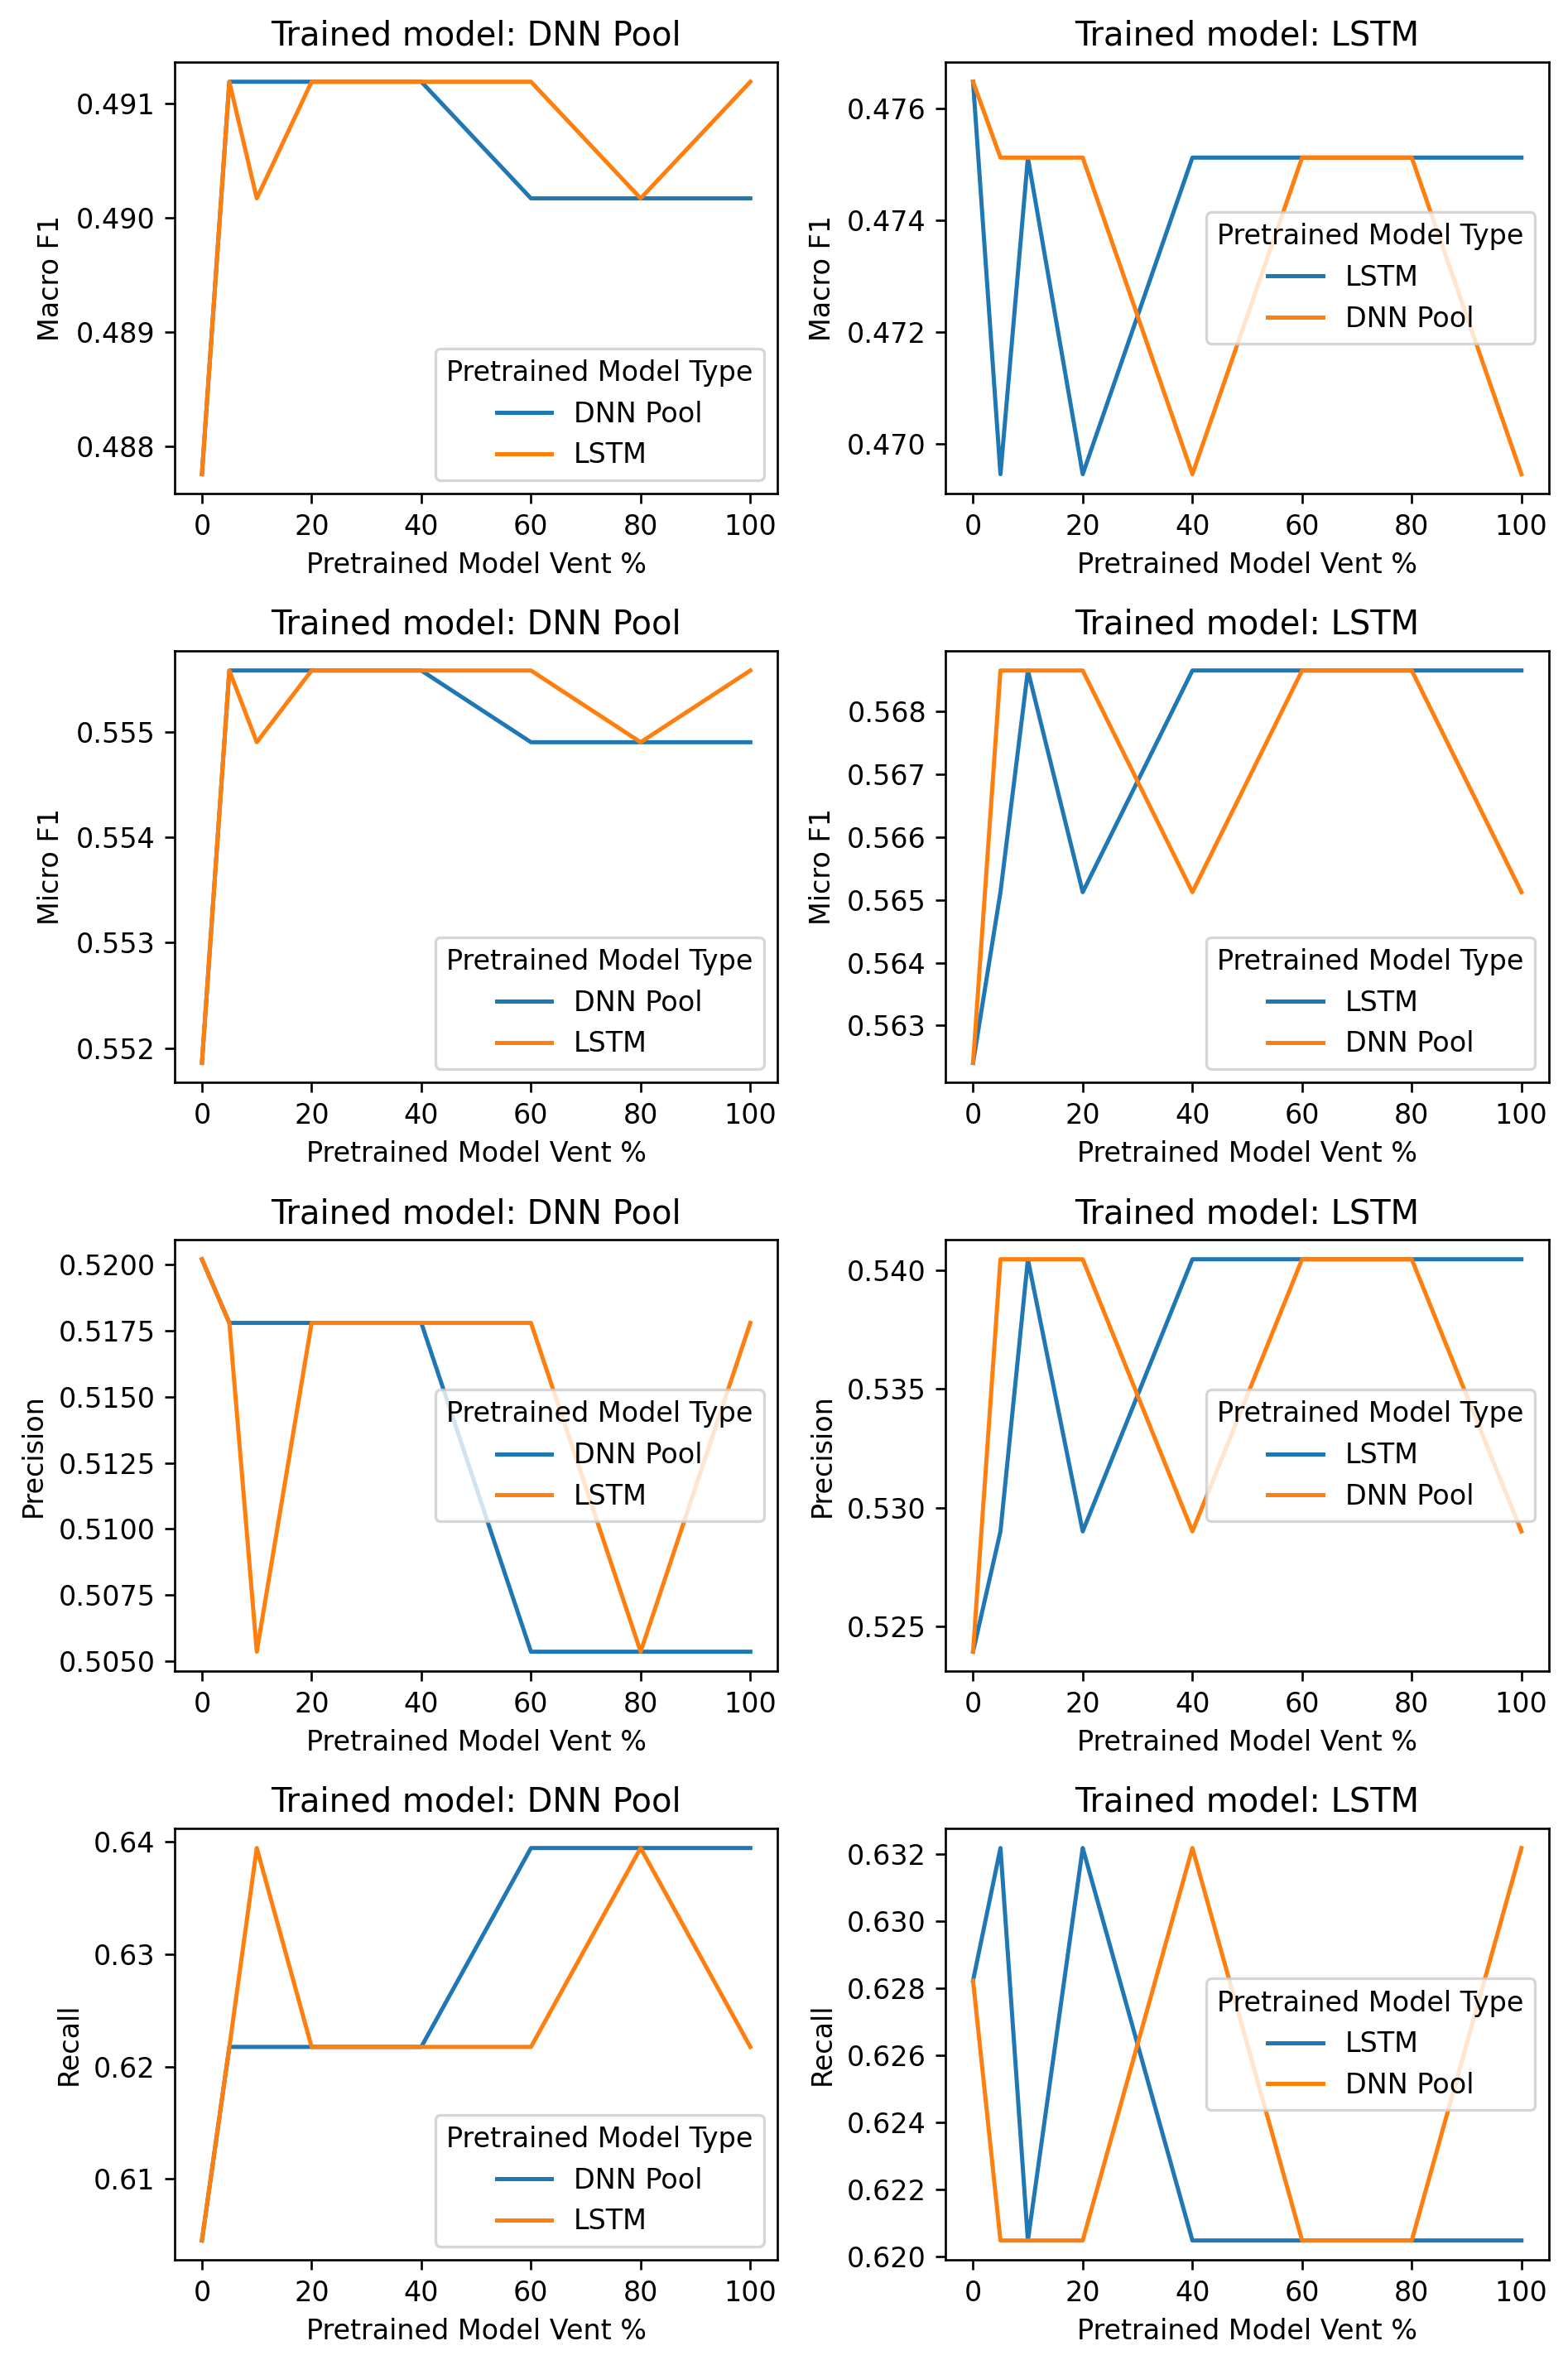

In [86]:
from matplotlib import pyplot as plt

fig_index = 1
num_figures = len(metrics)
num_model_types = complete_df.Model.unique().size
plt.figure(figsize=(8, 12), dpi=240)
for metric in metrics:
    for model_type, grp_df in complete_df.groupby('Model'):
        plt.subplot(num_figures, num_model_types, fig_index)
        fig_index += 1
        model_type = 'DNN Pool' if model_type == 'dnnpool' else 'LSTM'

        pretrained_groups = grp_df.PretrainedModelType.unique()
        pretrained_groups = [grp for grp in pretrained_groups if grp]
        for pretrained_type in pretrained_groups:
            df = grp_df[(grp_df.PretrainedModelType == pretrained_type) | (grp_df.PretrainedModelType == '')]
            df = df.sort_values(['DataSizePercent'])
            pretrained_type = 'DNN Pool' if pretrained_type == 'dnnpool' else 'LSTM'
            plt.plot(df.DataSizePercent, df[metric], label=pretrained_type)
        plt.title(f'Trained model: {model_type}')
        plt.ylabel(' '.join([x.capitalize() for x in metric.replace('_', ' ').split()[1:]]))
        plt.xlabel('Pretrained Model Vent %')
        plt.legend(title='Pretrained Model Type')
        
plt.tight_layout()